# 0. Carga de Datos

In [13]:
# ! pip install -r requirements.txt

In [14]:
# Librerias

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

import pandas as pd

# Números y Datos
import numpy as np
from scipy import stats
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import powerlaw

import requests 
import pickle


In [15]:

def download_file(url, output_path):
    """Descarga un archivo desde una URL a la ruta especificada"""
    # print(f"Descargando {url} a {output_path}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Asegura que la descarga fue exitosa
    
    with open(output_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    # print(f"Descarga completada: {output_path}")

In [16]:

# Descargar archivo zip de sujetos
download_file(
    "https://www.dropbox.com/scl/fi/ex7183k4zjgxbiw0diwi3/lesmiserables.txt?rlkey=zx5u5371s7gw3jlv50363jycf&dl=1", 
    "lesmiserables.txt"
)

# Descargar archivo CSV con coordenadas
download_file(
    "https://www.dropbox.com/scl/fi/2vl6hcazv5v13r7scodod/terrorist.txt?rlkey=l0n1rxbby6a8irtlyh1tbbweo&dl=1",
    "terrorist.txt"
)

# print("Todos los archivos han sido descargados y extraídos correctamente.")

# 1. Preprocesamiento

In [17]:
# Funciones

# Carga de datos---------------------------------------

def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData


# Borrar pesos de un grafo pesado-------------------------------

def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

# Para calcular eficientemente en grafos muy grandes una aproximación a distancias mínimas medias,  <𝑑> -------------

def sample_path_lengths(G, nodes=None, trials=1000):
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths



# 2. Analisis Descriptivo

In [18]:
# Comparaciones entre Los Miserables y Facebook

lesmis= read_graph_weighted('lesmiserables.txt')
print('Les Miserables')
print(lesmis)
print('Es dirigido?:',nx.is_directed(lesmis))
print('Es pesado?:',nx.is_weighted(lesmis))
print('Es conectado?:',nx.is_connected(lesmis))
print('')

#fb = read_graph('facebook.txt')
#print('Es dirigido?:',nx.is_directed(fb))
#print('Es pesado?:',nx.is_weighted(fb))
#print('Es conectado?:',nx.is_connected(fb))
#print('')

terr= read_graph_weighted('terrorist.txt')
print('Terrorist')
print(terr)
print('Es dirigido?:',nx.is_directed(terr))
print('Es pesado?:',nx.is_weighted(terr))
print('Es conectado?:',nx.is_connected(terr))
print('')

Les Miserables
Graph with 77 nodes and 254 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Terrorist
Graph with 64 nodes and 243 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True



In [19]:
# Eliminar el peso del grafo Les Miserables

lesmisU = lesmis.copy()
drop_weights(lesmisU)
print('Miserables sin peso')
print(lesmisU)
print('Es dirigido?:',nx.is_directed(lesmisU))
print('Es pesado?:',nx.is_weighted(lesmisU))
print('Es conectado?:',nx.is_connected(lesmisU))
print('')


terrU = terr.copy()
drop_weights(terrU)
print('Terroristas sin peso')
print(terrU)
print('Es dirigido?:',nx.is_directed(terrU))
print('Es pesado?:',nx.is_weighted(terrU))
print('Es conectado?:',nx.is_connected(terrU))
print('')


Miserables sin peso
Graph with 77 nodes and 254 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True

Terroristas sin peso
Graph with 64 nodes and 243 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



In [20]:
# Posiciones
pos_lm = nx.spring_layout(lesmisU,iterations=1000)
pos_terr = nx.spring_layout(terrU,iterations=1000)
#pos_fb=get_graph_pos('fb_pos.pkl')

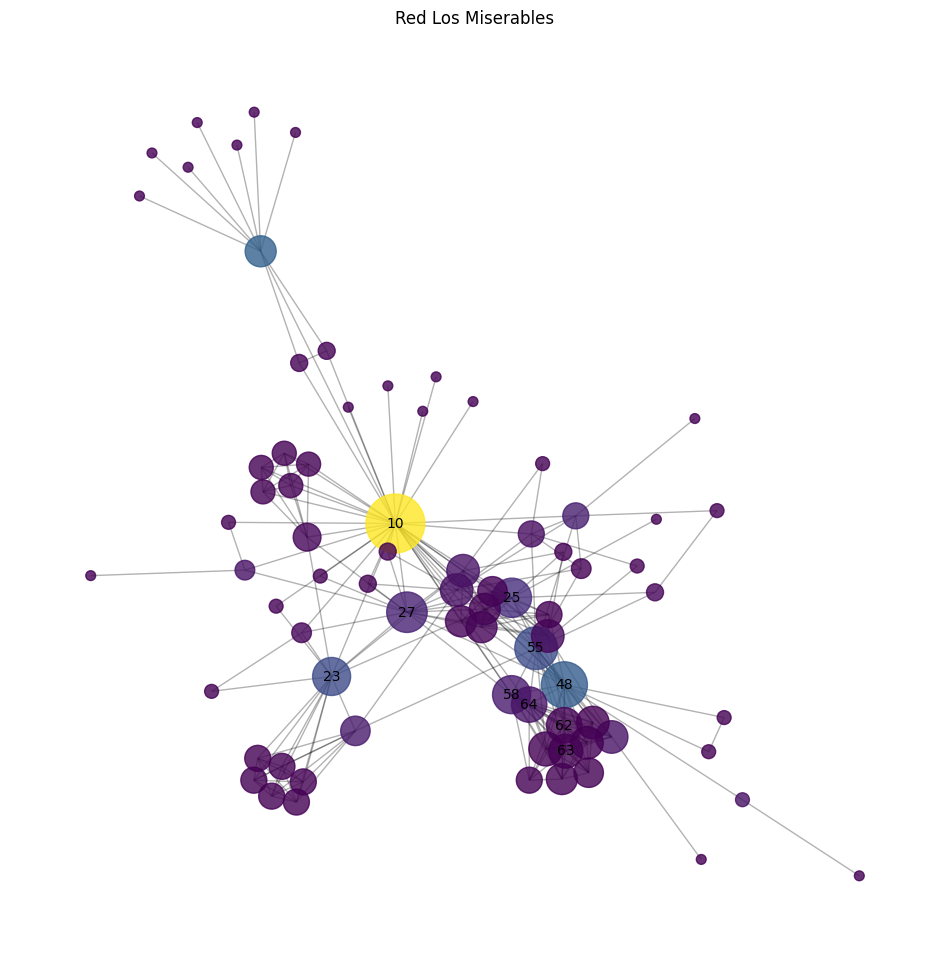

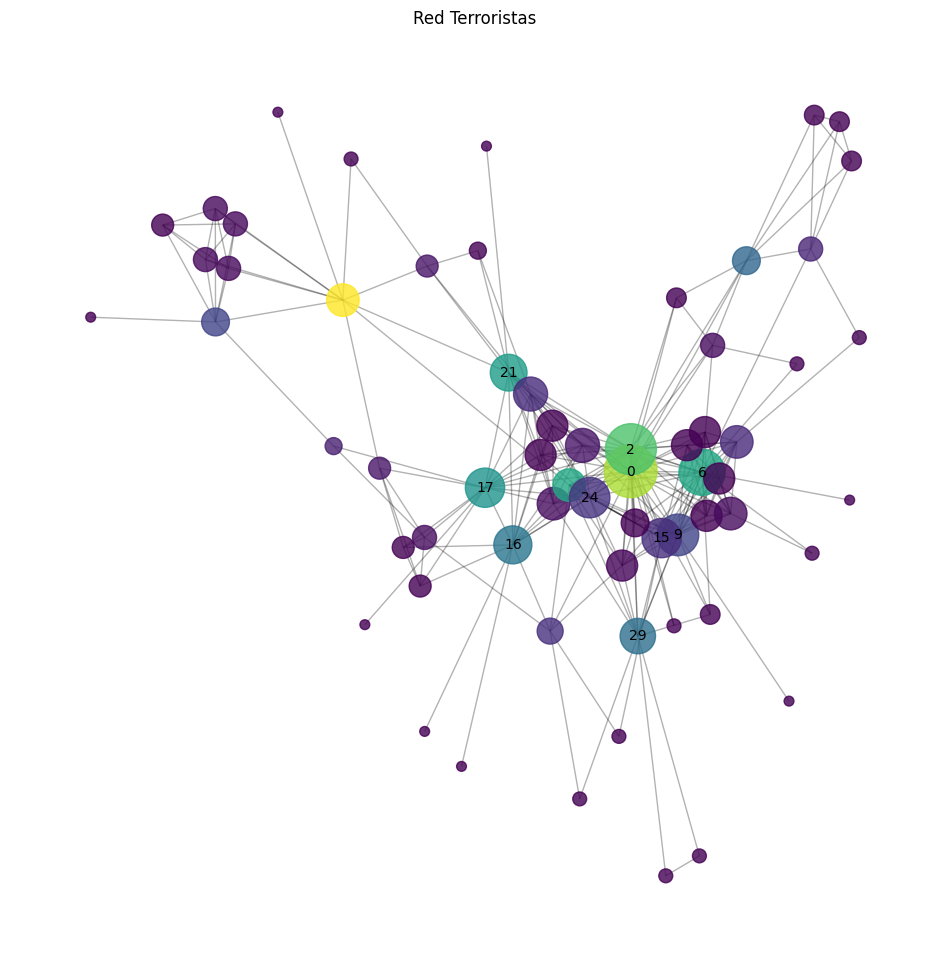

In [21]:
# Grafico descriptivo

# Miserables
# Tamaño de nodo segun grado
degrees_M = dict(lesmisU.degree())
node_sizes_M = [v * 50 for v in degrees_M.values()]

# Color de nodo segun centralidad
centrality_M = nx.betweenness_centrality(lesmisU)
node_colors_M = list(centrality_M.values())

# Etiquetas solo para los 10 nodos mas importantes segun grado
important_nodes_M = sorted(degrees_M, key=degrees_M.get, reverse=True)[:10]
labels_M = {node: node for node in important_nodes_M}

# Estetica general
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(lesmisU, pos_lm, node_size=node_sizes_M, node_color=node_colors_M, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(lesmisU, pos_lm, alpha=0.3)
nx.draw_networkx_labels(lesmisU, pos_lm, labels_M, font_size=10, font_color='black')

plt.title("Red Los Miserables")
plt.axis('off')
#plt.show()



# Terroristas
# Tamaño de nodo segun grado
degrees_F = dict(terrU.degree())
node_sizes_F = [v * 50 for v in degrees_F.values()]

# Color de nodo segun centralidad
centrality_F = nx.betweenness_centrality(terrU)
node_colors_F = list(centrality_F.values())

# Etiquetas solo para los 10 nodos mas importantes en grado
important_nodes_F = sorted(degrees_F, key=degrees_F.get, reverse=True)[:10]
labels_F = {node: node for node in important_nodes_F}

# Estetica general
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(terrU, pos_terr, node_size=node_sizes_F, node_color=node_colors_F, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(terrU, pos_terr, alpha=0.3)
nx.draw_networkx_labels(terrU, pos_terr, labels_F, font_size=10, font_color='black')

plt.title("Red Terroristas")
plt.axis('off')


plt.show()

# 3. Prototipos

Comparacion Les Miserables vs prototipos

In [22]:
def optimizar_p_watts_strogatz(red_observada):
    # Métricas de la red observada
    obs_clustering = nx.average_clustering(red_observada)
    obs_path_length = nx.average_shortest_path_length(red_observada)
    K_medio = 2 * red_observada.number_of_edges() / red_observada.number_of_nodes()
    
    # Rango de valores p a probar
    prob_valores = np.round(np.logspace(-3, -0.5, 40), 3)  # Valores entre 0.001 y ~0.3
    resultados = []
    
    for p in prob_valores:
        # Generar múltiples redes para este valor de p
        clustering_list = []
        path_length_list = []
        
        for i in range(50):  # 30 repeticiones para cada p
            G = nx.watts_strogatz_graph(
                red_observada.number_of_nodes(), 
                int(K_medio), 
                p, 
                seed=i
            )
            
            # Solo considerar grafos conexos
            if nx.is_connected(G):
                clustering_list.append(nx.average_clustering(G))
                path_length_list.append(nx.average_shortest_path_length(G))
        
        # Calcular promedios
        avg_clustering = np.mean(clustering_list)
        avg_path_length = np.mean(path_length_list)
        
        # Calcular error (distancia normalizada)
        error_clustering = abs(avg_clustering - obs_clustering) / obs_clustering
        error_path = abs(avg_path_length - obs_path_length) / obs_path_length
        error_total = error_clustering + error_path
        
        resultados.append({
            'p': p,
            'error': error_total,
            'avg_clustering': avg_clustering,
            'avg_path_length': avg_path_length
        })
    
    # Ordenar por error
    resultados = sorted(resultados, key=lambda x: x['error'])
    
    return resultados[0]['p']  # Devolver el mejor valor de p

In [23]:
def simular_prototipos(red, n = 1000, p_ws = 0.01):
    Kmedio = 2 * red.number_of_edges() / red.number_of_nodes()
    nodos = red.number_of_nodes()
    enlaces = red.number_of_edges()
    data = []
    limite = n + 1
    mcero = int(round(Kmedio / (2 - 1 / nodos)))
    contador = 0
    i = 0

    while contador < limite:
        d = {}

        i += 1
        # Creacion de grafos

        # Erdos-Renyi
        G_rnd = nx.gnm_random_graph(nodos, enlaces, seed=i)

        # Barabasi-Albert
        G_ba = nx.barabasi_albert_graph(nodos, mcero, seed=i)

        # Watts-Strogatz 
        G_ws = nx.watts_strogatz_graph(nodos, int(Kmedio), p_ws, seed=i)
    

        if not nx.is_connected(G_rnd) or not nx.is_connected(G_ws):
            continue

        # Calculo de metricas
        # Erdos-Renyi
        d['er_avg_clus'] = nx.average_clustering(G_rnd)
        d['er_avg_dist'] = nx.average_shortest_path_length(G_rnd)
        d['er_diameter'] = nx.diameter(G_rnd)
        d['er_density'] = nx.density(G_rnd)
        d['er_transitivity'] = nx.transitivity(G_rnd)

        # Barabasi-Albert
        d['ba_avg_clus'] = nx.average_clustering(G_ba)
        d['ba_avg_dist'] = nx.average_shortest_path_length(G_ba)
        d['ba_diameter'] = nx.diameter(G_ba)
        d['ba_density'] =  nx.density(G_ba)
        d['ba_transitivity'] = nx.transitivity(G_ba)
        d['ba_alpha'] = powerlaw.Fit([d for n, d in G_ba.degree], discrete=True, xmin=8).alpha

        # Watts-Strogatz
        d['ws_avg_clus'] = nx.average_clustering(G_ws)
        d['ws_avg_dist'] = nx.average_shortest_path_length(G_ws)
        d['ws_diameter'] = nx.diameter(G_ws)
        d['ws_density'] = nx.density(G_ws)
        d['ws_transitivity'] = nx.transitivity(G_ws)

        data.append(d)
        contador += 1

    df = pd.DataFrame(data)

    return df

In [24]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'er_media'])

NameError: name 'tabla_resumen' is not defined

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ba_media'])

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ws_media'])

In [12]:
def analisis_indicador(df, valores_reales, param, modelos = ['ba', 'er', 'ws']):

    resultados = {}



    for modelo in modelos:

        # Obtener las simulaciones para este modelo
        col = f'{modelo}_{param}'
        simulaciones = df[col].values
        
        # Calcular p-valor bidireccional (probabilidad de obtener un valor igual o más extremo)
        # Más extremo significa más lejano de la media
        media = simulaciones.mean()
        # Calculando un p-valor bidireccional verdadero
        distancia_a_media = abs(valores_reales[param] - simulaciones.mean())
        p_valor = (abs(simulaciones - simulaciones.mean()) >= distancia_a_media).mean()
        
        # Calcular percentil del valor observado
        percentil = stats.percentileofscore(simulaciones, valores_reales[param])
        
        # Calcular intervalo de confianza del 95%
        ic_95 = np.percentile(simulaciones, [2.5, 97.5])
        
        resultados[modelo] = {
            'p_valor': p_valor,
            'percentil': percentil,
            'media': media,
            'intervalo_confianza_95': ic_95,
            'dentro_ic': ic_95[0] <= valores_reales[param] <= ic_95[1]
        }

    return resultados


In [13]:
def plot_analisis_indicador(df, resultados,  valores_reales, param, modelos = ['ba', 'er', 'ws']):
    # Visualización de la posición del valor observado en cada distribución
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    for i, modelo in enumerate(modelos):
        col = f'{modelo}_{param}'
        ax[i].hist(df[col], bins=30, density=True, alpha=0.7)
        ax[i].axvline(valores_reales[param], color='r', linestyle='--', linewidth=2, 
                        label=f'Valor observado: {valores_reales[param]}')
        ax[i].axvline(resultados[modelo]['media'], color='green', linestyle='-', linewidth=1,
                        label=f'Media modelo: {resultados[modelo]["media"]:.4f}')
        ax[i].axvline(resultados[modelo]['intervalo_confianza_95'][0], color='black', linestyle=':', linewidth=1)
        ax[i].axvline(resultados[modelo]['intervalo_confianza_95'][1], color='black', linestyle=':', linewidth=1,
                        label='IC 95%')
        ax[i].set_title(f'Distribución {modelo.upper()} - {param}')
        ax[i].legend()

    plt.tight_layout()
    plt.show()


In [14]:
# tabla con valor promedio de indicador por modelo y su IC95
# Crear tabla con valores promedio e intervalos de confianza para cada modelo e indicador
def crear_tabla_resumen(df, valores_reales):
    # Definir las métricas y modelos
    metricas = ['avg_clus', 'avg_dist', 'diameter', 'density', 'transitivity']
    modelos = ['er', 'ba', 'ws']
    
    # Crear DataFrame vacío para almacenar resultados
    columnas = ['real']
    for modelo in modelos:
        columnas.extend([f'{modelo}_media', f'{modelo}_IC_inf', f'{modelo}_IC_sup'])
    
    resultados = pd.DataFrame(index=metricas, columns=columnas)
    
    # Agregar valores reales observados
    for metrica in metricas:
        resultados.loc[metrica, 'real'] = valores_reales[metrica]
    
    # Calcular estadísticas para cada combinación de modelo y métrica
    for metrica in metricas:
        for modelo in modelos:
            col = f"{modelo}_{metrica}"
            if col in df.columns:
                # Media
                resultados.loc[metrica, f'{modelo}_media'] = df[col].mean()
                
                # Intervalo de confianza al 95%
                ic_95 = np.percentile(df[col], [2.5, 97.5])
                resultados.loc[metrica, f'{modelo}_IC_inf'] = ic_95[0]
                resultados.loc[metrica, f'{modelo}_IC_sup'] = ic_95[1]
    
    # Formatear para mejorar la visualización
    return resultados.round(4)



In [15]:
def calcular_diferencias_absolutas(tabla_resumen, modelos):
    """
    Calcula las diferencias absolutas entre los valores reales y las medias de los modelos.
    
    Parámetros:
    -----------
    tabla_resumen : DataFrame
        Tabla con los valores reales y las medias de los modelos.
    modelos : list
        Lista de nombres de los modelos a comparar.
        
    Retorna:
    --------
    DataFrame
        Tabla con las diferencias absolutas para cada modelo y métrica.
    """
    # Crear una tabla de diferencias absolutas
    diferencias = pd.DataFrame(index=tabla_resumen.index, columns=[f'{modelo}_diff' for modelo in modelos])
    
    # Calcular diferencias absolutas para cada modelo
    for metrica in tabla_resumen.index:
        valor_real = tabla_resumen.loc[metrica, 'real']
        for modelo in modelos:
            media_modelo = tabla_resumen.loc[metrica, f'{modelo}_media']
            diferencias.loc[metrica, f'{modelo}_diff'] = abs(valor_real - media_modelo)
    
    # Formatear para mejorar la visualización
    return diferencias.round(4)


In [ ]:


p_ws = optimizar_p_watts_strogatz(lesmisU)
p_ws = np.round(p_ws, 4)
print(f"Valor de p óptimo para simular red de Watts-Strogatz: {p_ws}")

In [17]:
# 3. Prototipos
modelos = ['ba', 'er', 'ws']



df_lesmis = simular_prototipos(lesmisU, n=1000, p_ws=  p_ws= 0.01)


valores_reales_lesmis = {
    'avg_clus': nx.average_clustering(lesmisU),
    'avg_dist': nx.average_shortest_path_length(lesmisU),
    'diameter': nx.diameter(lesmisU),
    'density': nx.density(lesmisU),
    'transitivity': nx.transitivity(lesmisU)
}



In [ ]:
# Generar y mostrar la tabla
tabla_resumen = crear_tabla_resumen(df_lesmis, valores_reales_lesmis)



print(tabla_resumen)

In [ ]:

# Calcular y mostrar las diferencias
diferencias = calcular_diferencias_absolutas(tabla_resumen, modelos)
print("Diferencias absolutas entre valores reales y medias de los modelos:")
print(diferencias)


In [ ]:
# Valor observado
param = 'avg_clus'
resultados = analisis_indicador(df = df_lesmis, param = 'avg_clus', valores_reales = valores_reales_lesmis)


print(" Análisis del Coeficiente de clustering")

# Mostrar resultadoss
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_lesmis, resultados = resultados, valores_reales = valores_reales_lesmis, param = 'avg_clus')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_lesmis, param = 'avg_dist', valores_reales = valores_reales_lesmis)




print(" Análisis de la distancia promedio")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_lesmis  , resultados = resultados, valores_reales = valores_reales_lesmis, param = 'avg_dist')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_lesmis, param = 'diameter', valores_reales = valores_reales_lesmis)


print(" Análisis del Diametro")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_lesmis, resultados = resultados, valores_reales = valores_reales_lesmis, param = 'diameter')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_lesmis, param = 'transitivity', valores_reales = valores_reales_lesmis)


print(" Análisis de la transitividad")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_lesmis, resultados = resultados, valores_reales = valores_reales_lesmis, param = 'transitivity')

Terroristas

In [ ]:


p_ws = optimizar_p_watts_strogatz(terrU)
p_ws = np.round(p_ws, 4)
print(f"Valor de p óptimo para simular red de Watts-Strogatz: {p_ws}")

In [ ]:
# 3. Prototipos
modelos = ['ba', 'er', 'ws']
indicadores = ['avg_clus', 'avg_dist', 'diameter', 'density', 'transitivity']



df_terrU = simular_prototipos(terrU, n=1000, p_ws= 0.01)


valores_reales_terrU = {
    'avg_clus': nx.average_clustering(terrU),
    'avg_dist': nx.average_shortest_path_length(terrU),
    'diameter': nx.diameter(terrU),
    'density': nx.density(terrU),
    'transitivity': nx.transitivity(terrU)
}



In [ ]:
# Generar y mostrar la tabla
tabla_resumen = crear_tabla_resumen(df_terrU, valores_reales_terrU)



print(tabla_resumen)

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'er_media'])

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ba_media'])

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ws_media'])

# analisis vs prototipos terror

In [ ]:
# Valor observado
param = 'avg_clus'
resultados = analisis_indicador(df = df_terrU, param = 'avg_clus', valores_reales = valores_reales_terrU)


print(" Análisis del Coeficiente de clustering")

# Mostrar resultadoss
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_terrU, resultados = resultados, valores_reales = valores_reales_terrU, param = 'avg_clus')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_terrU, param = 'avg_dist', valores_reales = valores_reales_terrU)




print(" Análisis de la distancia promedio")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_terrU  , resultados = resultados, valores_reales = valores_reales_terrU, param = 'avg_dist')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_terrU, param = 'diameter',
                                 valores_reales = valores_reales_terrU)


print(" Análisis del Diametro")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_terrU, resultados = resultados, valores_reales = valores_reales_terrU, param = 'diameter')

In [ ]:
# Valor observado
resultados = analisis_indicador(df = df_terrU, param = 'transitivity', valores_reales = valores_reales_terrU)


print(" Análisis de la transitividad")
# Mostrar resultados
for modelo, res in resultados.items():
    print(f"Modelo {modelo.upper()}:")
    print(f"  Media: {res['media']:.4f}")
    print(f"  Percentil del valor observado: {res['percentil']:.1f}%")
    print(f"  P-valor: {res['p_valor']:.4f}")
    print(f"  IC 95%: [{res['intervalo_confianza_95'][0]:.4f}, {res['intervalo_confianza_95'][1]:.4f}]")
    print(f"  ¿Valor observado dentro del IC 95%?: {'Sí' if res['dentro_ic'] else 'No'}")
    print()

plot_analisis_indicador(df = df_terrU, resultados = resultados, valores_reales = valores_reales_terrU, param = 'transitivity')

## a. Random

In [ ]:
# Los miserables tienen 77 nodos y 254 enlaces
# Terroristas tiene 64 nodos y 243 enlaces

# Crear grafo aleatorio de los miserables
lesmi_random = nx.gnm_random_graph(77, 254)
nx.draw(lesmi_random, with_labels=True)
plt.title("Red Miserables random")
plt.axis('off')
plt.show()

# Crear grafo aleatorio de Terroristas
terr_random = nx.gnm_random_graph(64, 243)
nx.draw(terr_random, with_labels=True)
plt.title("Red Terroristas random")
plt.axis('off')
plt.show()

Metricas locales para random

In [ ]:
# distribución de grado

degrees_M_hist = [lesmisU.degree(n) for n in lesmisU.nodes()]
degrees_M_random_hist = [lesmi_random.degree(n) for n in lesmi_random.nodes()]


degrees_F_hist = [terrU.degree(n) for n in terrU.nodes()]
degrees_F_random_hist = [terr_random.degree(n) for n in terr_random.nodes()]

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(degrees_M_hist, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(degrees_M_random_hist, bins=10, alpha=0.6, label='Miserables Random', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Les Misérables')
plt.legend()
plt.grid(True)

# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(degrees_F_hist, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(degrees_F_random_hist, bins=10, alpha=0.6, label='Terroristas Random', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Terroristas')
#plt.xlim(0,300)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Medidas de centralidad


#Centralidad de grado
centralidad_M = nx.degree_centrality(lesmisU)
centralidad_M_random = nx.degree_centrality(lesmi_random)

centralidad_F = nx.degree_centrality(terrU)
centralidad_F_random = nx.degree_centrality(terr_random)

valores_M = list(centralidad_M.values())
valores_M_random = list(centralidad_M_random.values())

valores_F = list(centralidad_F.values())
valores_F_random = list(centralidad_F_random.values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(valores_M, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_random, bins=10, alpha=0.6, label='Random', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Les Misérables vs Random')
plt.legend()
plt.grid(True)


# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(valores_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_random, bins=10, alpha=0.6, label='Random', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Terroristas vs Random')
plt.legend()
plt.grid(True)



plt.show()


In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'er_media'])

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ba_media'])

In [ ]:
np.abs(tabla_resumen.loc[:,  'real'] - tabla_resumen.loc[:,  'ws_media'])

In [ ]:
# Betweenness (intermediación)
betweenness_M = nx.betweenness_centrality(lesmisU)
betweenness_M_random = nx.betweenness_centrality(lesmi_random)
valores_M_bet = list(betweenness_M.values())
valores_M_random_bet = list(betweenness_M_random.values())

betweenness_F = nx.betweenness_centrality(terrU)
betweenness_F_random = nx.betweenness_centrality(terr_random)
valores_F_bet = list(betweenness_F.values())
valores_F_random_bet = list(betweenness_F_random.values())

# Les Misérables
plt.figure(figsize=(6, 5))
plt.hist(valores_M_bet, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_random_bet, bins=10, alpha=0.6, label='Random', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Les Misérables vs Random')
plt.legend()
plt.grid(True)

# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(valores_F_bet, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_random_bet, bins=10, alpha=0.6, label='Random', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Terroristas vs Random')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Cercania

close_M = list(nx.closeness_centrality(lesmisU).values())
close_M_random = list(nx.closeness_centrality(lesmi_random).values())

close_F = list(nx.closeness_centrality(terrU).values())
close_F_random = list(nx.closeness_centrality(terr_random).values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(close_M, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(close_M_random, bins=10, alpha=0.6, label='Miserables Random', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Les Misérables - Random')
plt.legend()
plt.grid(True)

# Facebook
plt.figure(figsize=(6, 5))
plt.hist(close_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(close_F_random, bins=10, alpha=0.6, label='Terroristas_Random', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Terroristas - Random')
plt.legend()
plt.grid(True)

plt.show()

## b. Barabási-Albert

El modelo Barabasi-Albert parte de una red com  mo  nodos, y va agregando sucesivamente nuevos nodos con  m=mo  enlaces, que se conectan a los nodos pre-existentes con una probabildad  pi  que es proporcional al grado del nodo pre-existente (o sea, la probabilidad de que se conecte al nodo  i  es  pi∝ki  ).

El grado medio  <k>  de una red Barabasi Albert es:  <k>BA=2mo−mo/N

Que tiende a  2mo  para redes suficientemente grandes... Si queremos matchear  <k>BA  al grado medio  <k>observado  hay que elegir el  mo  apropiadamente

In [ ]:
# Los miserables tienen 77 nodos y 254 enlaces

grado_medio_obs_lesmi = 2 * lesmisU.number_of_edges() / lesmisU.number_of_nodes()

mcero_lesmi = int(round(grado_medio_obs_lesmi / (2 - 1 / lesmisU.number_of_nodes())))

lesmi_ba = nx.barabasi_albert_graph(77,mcero_lesmi)

pos = nx.spring_layout(lesmi_ba, seed=42)  # `seed` para que sea reproducible
nx.draw(lesmi_ba, pos, node_size=30, with_labels=False)
plt.title("Red Miserables - Barabási-Albert")
plt.axis('off')
plt.show()

#Se ve muy parecida a una random porque BA requiere un M0 entre 2 y 3. Cuando pasa de 3 es casi una random. En este caso M0 = 3


In [ ]:
# Terroristas tiene 64 nodos y 243 enlaces

grado_medio_obs_fb = 2 * terrU.number_of_edges() / terrU.number_of_nodes()

mcero_fb = int(round(grado_medio_obs_fb / (2 - 1 / terrU.number_of_nodes())))

print(mcero_fb)

fb_ba = nx.barabasi_albert_graph(64,mcero_fb)

pos = nx.spring_layout(fb_ba, seed=42)  # `seed` para que sea reproducible
nx.draw(fb_ba, pos, node_size=5, with_labels=False)
plt.title("Red Terroristas -  Barabási-Albert")
plt.axis('off')
plt.show()


Metricas globales para Barabási-Albert

In [ ]:
datos_ba = {
    "Grafo": ["LesMis", "LesMis_BA", "Terroristas", "Terroristas_BA"],
    "Diámetro": [
        nx.diameter(lesmisU),
        nx.diameter(lesmi_ba),
        nx.diameter(terrU),
        nx.diameter(fb_ba)
    ],
    "Densidad": [
        nx.density(lesmisU),
        nx.density(lesmi_ba),
        nx.density(terrU),
        nx.density(fb_ba)
    ],
    "Transitividad": [
        nx.transitivity(lesmisU),
        nx.transitivity(lesmi_ba),
        nx.transitivity(terrU),
        nx.transitivity(fb_ba)
    ],
    "Clustering promedio": [
        nx.average_clustering(lesmisU),
        nx.average_clustering(lesmi_ba),
        nx.average_clustering(terrU),
        nx.average_clustering(fb_ba)
    ]
}

# Crear la tabla
metricas_ba = pd.DataFrame(datos_ba)

# Mostrarla
print(metricas_ba)


Metricas locales para BA

In [ ]:
# distribución de grado

degrees_M_hist = [lesmisU.degree(n) for n in lesmisU.nodes()]
degrees_M_ba_hist = [lesmi_ba.degree(n) for n in lesmi_ba.nodes()]


degrees_F_hist = [terrU.degree(n) for n in terrU.nodes()]
degrees_F_ba_hist = [fb_ba.degree(n) for n in fb_ba.nodes()]

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(degrees_M_hist, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(degrees_M_ba_hist, bins=10, alpha=0.6, label='Miserables BA', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Les Misérables')
plt.legend()
plt.grid(True)

# Facebook
plt.figure(figsize=(6, 5))
plt.hist(degrees_F_hist, bins=10, alpha=0.6, label='Terrorirstas', density=True)
plt.hist(degrees_F_ba_hist, bins=10, alpha=0.6, label='Terroristas BA', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Terroristas')
#plt.xlim(0,300)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Medidas de centralidad


#Centralidad de grado
centralidad_M = nx.degree_centrality(lesmisU)
centralidad_M_BA = nx.degree_centrality(lesmi_ba)

centralidad_F = nx.degree_centrality(terrU)
centralidad_F_BA = nx.degree_centrality(fb_ba)

valores_M = list(centralidad_M.values())
valores_M_BA = list(centralidad_M_BA.values())

valores_F = list(centralidad_F.values())
valores_F_BA = list(centralidad_F_BA.values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(valores_M, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_BA, bins=10, alpha=0.6, label='BA', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Les Misérables vs BA')
plt.legend()
plt.grid(True)


# Facebook
plt.figure(figsize=(6, 5))
plt.hist(valores_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_BA, bins=10, alpha=0.6, label='BA', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Terroristas vs BA')
plt.legend()
plt.grid(True)



plt.show()


In [ ]:
# Betweenness (intermediación)
betweenness_M = nx.betweenness_centrality(lesmisU)
betweenness_M_BA = nx.betweenness_centrality(lesmi_ba)
valores_M_bet = list(betweenness_M.values())
valores_M_BA_bet = list(betweenness_M_BA.values())

betweenness_F = nx.betweenness_centrality(terrU)
betweenness_F_BA = nx.betweenness_centrality(fb_ba)
valores_F_bet = list(betweenness_F.values())
valores_F_BA_bet = list(betweenness_F_BA.values())

# Les Misérables
plt.figure(figsize=(6, 5))
plt.hist(valores_M_bet, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_BA_bet, bins=10, alpha=0.6, label='BA', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Les Misérables vs BA')
plt.legend()
plt.grid(True)

# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(valores_F_bet, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_BA_bet, bins=10, alpha=0.6, label='BA', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Terroristas vs BA')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Cercania

close_M = list(nx.closeness_centrality(lesmisU).values())
close_M_BA = list(nx.closeness_centrality(lesmi_ba).values())

close_F = list(nx.closeness_centrality(terrU).values())
close_F_BA = list(nx.closeness_centrality(fb_ba).values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(close_M, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(close_M_BA, bins=10, alpha=0.6, label='Miserables BA', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Les Misérables - BA')
plt.legend()
plt.grid(True)

# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(close_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(close_F_BA, bins=10, alpha=0.6, label='Terroristas BA', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Terroristas - BA')
plt.legend()
plt.grid(True)

plt.show()

## c. Watts-Strogratz



In [ ]:
# Datos

#LesMis
n_lesmi = lesmisU.number_of_nodes()
grado_medio_obs_lesmi = 2 * lesmisU.number_of_edges() / n_lesmi
k_lesmi = int(round(grado_medio_obs_lesmi)) #tiene que ser par. Para eso:
if k_lesmi % 2 != 0:
    k_lesmi += 1

#n Watts-Strogatz el grado medio es k, porque cada nodo se conecta a k vecinos antes del recableado

p = 0.01 #probabilidad de recableado (deberia ser 1%)

print(n_lesmi)
print(k_lesmi)


#Facebook
n_fb = terrU.number_of_nodes()
grado_medio_obs_fb = 2 * terrU.number_of_edges() / n_fb
k_fb = int(round(grado_medio_obs_fb)) #tiene que ser par. Para eso:
if k_fb % 2 != 0:
    k_fb += 1

p = 0.01
print(n_fb)
print(k_fb)


In [ ]:
# Grafo Small World de los miserables
lesmi_small = nx.watts_strogatz_graph(n_lesmi, k_lesmi, p) # n nodos, k vecinos, p probabilidad
pos_lesmi = nx.spring_layout(lesmi_small, seed=42)
nx.draw(lesmi_small, pos_lesmi, node_size=30, with_labels=False)
plt.title("Red Los Miserables Small World")
plt.axis('off')
plt.show()

In [ ]:
# Grafo Small World FB
fb_small = nx.watts_strogatz_graph(n_fb, k_fb, p) # n nodos, k vecinos, p probabilidad
pos_fb = nx.spring_layout(fb_small, seed=42)
nx.draw(fb_small, pos_fb, node_size=20, with_labels=False)
plt.title("Red Terroristas Small World")
plt.axis('off')
plt.show()


### Métricas Globales Small World

In [ ]:
datos_small = {
    "Grafo": ["LesMis", "LesMis_Small", "Terroristas", "Terroristas_Small"],
    "Diámetro": [
        nx.diameter(lesmisU),
        nx.diameter(lesmi_small),
        nx.diameter(terrU),
        nx.diameter(fb_small)
    ],
    "Densidad": [
        nx.density(lesmisU),
        nx.density(lesmi_small),
        nx.density(terrU),
        nx.density(fb_small)
    ],
    "Transitividad": [
        nx.transitivity(lesmisU),
        nx.transitivity(lesmi_small),
        nx.transitivity(terrU),
        nx.transitivity(fb_small)
    ],
    "Clustering promedio": [
        nx.average_clustering(lesmisU),
        nx.average_clustering(lesmi_small),
        nx.average_clustering(terrU),
        nx.average_clustering(fb_small)
    ]
}

# Crear la tabla
metricas_small = pd.DataFrame(datos_small)

# Mostrarla
print(metricas_small)


Interpretación: <br>
-Diametro en LesMis no se modifica, modelo logra representarlo bien. En fb baja a la mitad, osea genera una red más compacta (atajos que acortan caminos, propio de mundo pequeño) <br>
-Densidad se mantiene similar (aunque un poco más alta) => Cantidad de enlaces está bien representada en el prototipo<br>
-Transitividad baja un poco en LesMis y sube un poco en FB. (preserva bien triangulos locales)** <br>
-Clustering Promedio: en ambos casos baja debido a que small world tiene menos hubs <br>


**
✅ El modelo Watts–Strogatz, al construir un grafo donde cada nodo se conecta con sus vecinos cercanos (como en un anillo) y solo aleatoriza un pequeño porcentaje de los enlaces, preserva naturalmente muchos triángulos.

✅ Al hacer eso, la cantidad de triángulos y la transitividad global no bajan drásticamente — como sí podría pasar si usaras un modelo como Barabási-Albert, que no prioriza el clustering.

✅ En tu caso particular, en Facebook:

El grafo original tiene una transitividad ≈ 0.519,

Y el Facebook_Small (modelo Small World) tiene una transitividad ≈ 0.533.

¡Subió un poquito!

¿Por qué?
Porque en el modelo Small World, al empezar de una red regular muy conectada localmente (con vecinos cercanos) y hacer pocos cambios aleatorios, aumenta la posibilidad de formar nuevos triángulos accidentalmente.

En redes grandes como Facebook, este efecto se nota más porque hay más nodos y más chances de formar esos triángulos extra cuando rewireás algunas conexiones.

### Métricas Locales Small World

In [ ]:
# distribución de grado

degrees_M_hist = [lesmisU.degree(n) for n in lesmisU.nodes()]
degrees_M_small_hist = [lesmi_small.degree(n) for n in lesmi_small.nodes()]


degrees_F_hist = [terrU.degree(n) for n in terrU.nodes()]
degrees_F_small_hist = [fb_small.degree(n) for n in fb_small.nodes()]

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(degrees_M_hist, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(degrees_M_small_hist, bins=10, alpha=0.6, label='Miserables Small World', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Les Misérables')
plt.legend()
plt.grid(True)

# Facebook
plt.figure(figsize=(6, 5))
plt.hist(degrees_F_hist, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(degrees_F_small_hist, bins=10, alpha=0.6, label='Terroristas Small World', density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados - Terroristas')
#plt.xlim(0,300)
plt.legend()
plt.grid(True)

plt.show()

Interpretación: <br>
LesMis: red real es más dispersa, hay muchos entre 1 y 5, pero tambien hay uno de 35 (red heterogenea). Mientras que prototipo está concentrado entre 6 y 10 y no hay hubs. Esto refleja que LesMis real tiene nodos muy centrales en protagonistas (Jean Valjean o Javert), mientras que el prototipo le da una estructura más regular sin hubs. <br>

FB: En facebook se da una lógica similar pero más extrema. <br>


Watts–Strogatz produce redes con clustering alto y caminos cortos, pero sin hubs. Las redes reales (tanto LesMis como Facebook) tienen una estructura heterogénea que no es bien capturada por el modelo Small World.



### Medidas de Centralidad

In [ ]:
# Medidas de centralidad


#Centralidad de grado
centralidad_M = nx.degree_centrality(lesmisU)
centralidad_M_Small = nx.degree_centrality(lesmi_small)

centralidad_F = nx.degree_centrality(terrU)
centralidad_F_Small = nx.degree_centrality(fb_small)

valores_M = list(centralidad_M.values())
valores_M_Small= list(centralidad_M_Small.values())

valores_F = list(centralidad_F.values())
valores_F_Small = list(centralidad_F_Small.values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(valores_M, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_Small, bins=10, alpha=0.6, label='LesMis Small World', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Les Misérables vs Small World')
plt.legend()
plt.grid(True)


# Facebook
plt.figure(figsize=(6, 5))
plt.hist(valores_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_Small, bins=10, alpha=0.6, label='Terroristas Small World', density=True)
plt.xlabel('Centralidad de grado')
plt.ylabel('Distribución de frecuencia')
plt.title('Distribución de centralidad de grado - Terroristas vs Small World')
#plt.xlim(0, 0.08)
plt.legend()
plt.grid(True)



plt.show()


Interpretación: Lógica similar a distribución de grados. En redes reales hay mucha variabilidad mientras que Small World lo regulariza

In [ ]:
# Betweenness (intermediación)
betweenness_M = nx.betweenness_centrality(lesmisU)
betweenness_M_Small = nx.betweenness_centrality(lesmi_small)
valores_M_bet = list(betweenness_M.values())
valores_M_Small_bet = list(betweenness_M_Small.values())

betweenness_F = nx.betweenness_centrality(terrU)
betweenness_F_Small = nx.betweenness_centrality(fb_small)
valores_F_bet = list(betweenness_F.values())
valores_F_Small_bet = list(betweenness_F_Small.values())

# Les Misérables
plt.figure(figsize=(6, 5))
plt.hist(valores_M_bet, bins=10, alpha=0.6, label='Les Misérables', density=True)
plt.hist(valores_M_Small_bet, bins=10, alpha=0.6, label='LesMis Small World', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Les Misérables vs Small World')
plt.legend()
plt.grid(True)

# Terroristas
plt.figure(figsize=(6, 5))
plt.hist(valores_F_bet, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(valores_F_Small_bet, bins=10, alpha=0.6, label='Terroristas Small World', density=True)
plt.xlabel('Centralidad de intermediación')
plt.ylabel('Distribución')
plt.title('Intermediación - Terroristas vs Small World')
#plt.yscale('log') #pruebo escala logaritmica para que grafico se vea bien
plt.legend()
plt.grid(True)

#probar si con esto se puede mostrar FB small world
#valores_F_Small_bet_filtrado = [v for v in valores_F_Small_bet if v > 0]
#epsilon = 1e-6
#valores_F_Small_bet = [v + epsilon for v in valores_F_Small_bet]



plt.show()

Interpretación: <br>
LesMis: en red real mayoría de nodos tienen centralidad de intermediación baja, aunque hay unos pocos con alta (>0.5), debido a que protagonistas conectan muchos caminos (son puentes de la red). En el prototipo se concentran en valores bajos y nodos más parecidos en su rol de intermediadores. <br>

FB: mayoría de usarios no son críticos para la conectividad de la red (betweness tiende a cero), y tenes pocos superhubs. Version Prototipo no hay hubs ni nodos criticos extremos. En el prototipo (quizas por p=0.1 y alto k relativo inicial, todos los nodos tienen caminos cortos hacia los demás, por lo que la centralidad betweeness es muy baja y no se ve (segun gpt terminan en el bin 0 y no los muestra porque log(0) no existe, ver si hay forma de mostrarlo). Osea, intermediaciones en prototipo son practicamente nulas (ningun usuario es especial), esto viene de que Watts-Strogatz no genera hubs de control.  





In [ ]:
# Closeness

close_M = list(nx.closeness_centrality(lesmisU).values())
close_M_Small = list(nx.closeness_centrality(lesmi_small).values())

close_F = list(nx.closeness_centrality(terrU).values())
close_F_Small = list(nx.closeness_centrality(fb_small).values())

# Miserables
plt.figure(figsize=(6, 5))
plt.hist(close_M, bins=10, alpha=0.6, label='Miserables', density=True)
plt.hist(close_M_Small, bins=10, alpha=0.6, label='LesMis Small World', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Les Misérables - Small World')
plt.legend()
plt.grid(True)

# Facebook
plt.figure(figsize=(6, 5))
plt.hist(close_F, bins=10, alpha=0.6, label='Terroristas', density=True)
plt.hist(close_F_Small, bins=10, alpha=0.6, label='Terroristas Small World', density=True)
plt.xlabel('Centralidad de cercanía')
plt.ylabel('Distribución')
plt.title('Closeness Centrality - Terroristas - Small World')
plt.legend()
plt.grid(True)

plt.show()

Interpretación: <br>
LesMis: Cercanía del modelo es parecida pero más concentrada, tiene un pico bien definido. En la real se notan nodos más perifericos (valor bajo) y otros más concentrados (protagonistas). Prototipo es más homogeneo. <br>


FB: red real es dispersa, mientras que modelo está super concentrado. En red real closeness es más homogenea que en LesMis. Modelo le da a todos los usuarios de FB practicamente la misma densidad.  <br>

✅ Las redes reales (Les Misérables y Facebook) presentan heterogeneidad natural: hay individuos que, por su posición, son más accesibles o más estratégicos que otros. <br>

✅ Las redes Small World modelan un mundo donde todos los nodos están a una distancia razonable y bastante similar del resto.

# 5. Apendice

Analisis exploratorio inicial (se puede borrar de aca para abajo)-------------------------------

In [ ]:
# Histograma de distribución de grado

plt.figure(figsize=(6, 4))
degrees_M_hist = [lesmisU.degree(n) for n in lesmisU.nodes()]
histM, binsM, _ = plt.hist(degrees_M_hist, bins=30, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados Miserables')

plt.figure(figsize=(6, 4))
degrees_F_hist = [fb.degree(n) for n in fb.nodes()]
histF, binsF, _ = plt.hist(degrees_F_hist, bins=30, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados Facebook')

plt.figure(figsize=(6, 4))
degrees_F_hist = [fb.degree(n) for n in fb.nodes()]
histF, binsF, _ = plt.hist(degrees_F_hist, bins=80, density=True)
plt.xlim(0, 300)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados Facebook (detalle)')

plt.show()

In [ ]:
# Histograma superpuesto

degrees_F_hist = [fb.degree(n) for n in fb.nodes()]
plt.hist(degrees_M_hist, bins=10, alpha=0.6, label='Los Miserables', density=True)
plt.hist(degrees_F_hist, bins=10, alpha=0.6, label='Facebook', density=True)

plt.xlabel('k')
plt.ylabel('p(k)')
plt.legend()
plt.title('Distribución de grados comparada')
plt.xlim(0, 400)
plt.grid(True)
plt.show()

In [ ]:
# Diametro

nx.diameter(lesmisU), nx.diameter(fb)

In [ ]:
# Densidad

nx.density(lesmisU), nx.density(fb)

In [ ]:
# Coeficiente de clustering global

nx.average_clustering(lesmisU), nx.average_clustering(fb)

In [ ]:
# Transitividad

nx.transitivity(lesmisU), nx.transitivity(fb)

In [ ]:
# Asortividad

nx.degree_assortativity_coefficient(lesmisU), nx.degree_assortativity_coefficient(fb)